In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from natsort import natsorted
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.cm as cm
from pygam import LinearGAM, s, f
from scipy import stats
from enigmatoolbox.permutation_testing import spin_test, shuf_test
sns.set(font_scale=1.5, style="white")

In [2]:
df = pd.read_csv('../../Dataset/childhood/rna/brodmann_schaefer_0.5.csv')
df_copy = df.iloc[:200, 2:]
df.iloc[:200, 2:] = df.iloc[:200, 2:].values + df.iloc[200:, 2:].values
df.iloc[200:, 2:] = df_copy.values + df.iloc[200:, 2:].values

In [3]:
regionname = pd.read_csv('../../Dataset/childhood/atlas/schaefer400_regions.csv')
sarank = pd.read_csv('../../Dataset/childhood/saaxis/Sensorimotor_Association_Axis_AverageRanks.csv')
sarank = pd.concat([regionname.reset_index(drop=True), sarank.reset_index(drop=True)],axis=1)
sarank = sarank.loc[:, ['name', 'finalrank.wholebrain']]

In [4]:
# read expression data
data_dir = '../../Dataset/childhood/rna'
gene_columns = pd.read_csv(os.path.join(data_dir, 'columns_metadata.csv'))
gene_rows = pd.read_csv(os.path.join(data_dir, 'rows_metadata.csv'))
gene_columns['id'] = range(1, len(gene_columns) + 1)
expr_matrix = pd.read_csv(os.path.join(data_dir, 'expression_matrix.csv'), header=None)
expr_matrix = expr_matrix.iloc[:, 1:] 

In [5]:
# remove genes without an entrez id
expr_subset = expr_matrix[~gene_rows['entrez_id'].isna()]
rows_subset = gene_rows[~gene_rows['entrez_id'].isna()]

In [6]:
log2_expr = np.log2(expr_subset + 1)
log2_expr['entrez_id'] = rows_subset['entrez_id']

In [7]:
markers  = ['PVALB', 'SST', 'VIP', 'GAD1', 'GAD2'] #PVALB
for marker in markers:
    ids = gene_rows[gene_rows.gene_symbol==marker].entrez_id.values[0]
    df_marker = log2_expr[log2_expr.entrez_id==ids].iloc[:, :-1].T.values
    gene_columns[marker] = df_marker

In [8]:
sa_cortex = np.unique([x for x in gene_columns.structure_name if 'cortex' in x])
sa_cortex = pd.DataFrame([x for x in sa_cortex if 'cereb' not in x])
sa_cortex.columns = ['structure_name']

In [9]:
adults = [ '18 yrs', '19 yrs', '21 yrs','23 yrs']
cbpd_wide = ['8 yrs', '11 yrs','13 yrs']

In [10]:
brodregion = pd.read_csv('../../Dataset/childhood/rna/brodmann.csv')
saorder = pd.DataFrame([np.arange(11), ['Visual', 'Auditory', 'Sensory', 'Motor', 'IPC', 'STC', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC']]).T
saorder.columns = ['sa', 'group']

In [11]:
child_original = pd.read_csv('../../Derivatives/childhood/original_motion_1mm.csv')
adult_original = pd.read_csv('../../Derivatives/adult/original.csv')

In [12]:
Visual = [x for x in df.columns if 'BA17' in x]
Auditory = [x for x in df.columns if 'BA41' in x]
Sensory =  [x for x in df.columns if 'BA1_3' in x] + [x for x in df.columns if 'BA2' in x] # [x for x in sarank.name.values if 'S2' in x] +
Motor = [x for x in df.columns if 'BA4' in x]
vPFC = [x for x in df.columns if 'BA44' in x] +  [x for x in df.columns if 'BA45' in x]
dPFC = [x for x in df.columns if 'BA8' in x] + [x for x in df.columns if 'BA9' in x] + [x for x in df.columns if 'BA46' in x]
OFC = [x for x in df.columns if 'BA11' in x] + [x for x in df.columns if 'BA12' in x]+ [x for x in df.columns if 'BA13' in x]  + [x for x in df.columns if 'BA14_' in x]
TEv = [x for x in df.columns if 'BA20' in x]
ACC = [x for x in df.columns if 'BA24' in x] + [x for x in df.columns if 'BA25' in x] + [x for x in df.columns if 'BA32' in x]
STC = [x for x in df.columns if 'BA22' in x]
IPC = [x for x in df.columns if 'BA39' in x] +  [x for x in df.columns if 'BA40' in x]

child_regions = []
adult_regions = []
sas = []
for x in [Sensory, Auditory, Motor, Visual, vPFC, dPFC, OFC, TEv, ACC, STC, IPC]:
    print(x)
    roi  = df.loc[:, x].sum(axis=1)>0
    child_original['roi']=roi
    adult_original['roi']=roi
    child_regions.append(child_original[child_original.roi==True].mean()['H'])
    adult_regions.append(adult_original[adult_original.roi==True].mean()['H'])
    sas.append(child_original[child_original.roi==True].mean()['SArank'])

['BA1_3', 'BA2', 'BA20', 'BA21', 'BA22', 'BA23', 'BA24', 'BA25', 'BA26_29_30', 'BA27', 'BA28']
['BA41_42_52']
['BA4', 'BA40', 'BA41_42_52', 'BA43', 'BA44', 'BA45', 'BA46', 'BA47']
['BA17']
['BA44', 'BA45']
['BA8', 'BA9', 'BA46']
['BA11', 'BA13']
['BA20']
['BA24', 'BA25', 'BA32']
['BA22']
['BA39', 'BA40']


In [13]:
child = pd.DataFrame([['Sensory', 'Auditory', 'Motor', 'Visual', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC', 'STC', 'IPC'], child_regions, sas]).T.sort_values(2).reset_index(drop=True)
child.columns = ['region', 'H', 'sa']
adult = pd.DataFrame([['Sensory', 'Auditory', 'Motor', 'Visual', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC', 'STC', 'IPC'], adult_regions, sas]).T.sort_values(2).reset_index(drop=True)
adult.columns = ['region', 'H', 'sa']

In [14]:
sa_cortex['region'] = ['ACC', 'dPFC', 'TEv', '-', 'OFC', '-', 'STC', 'IPC', 'Auditory', 'Motor', '-', 'Sensory', 'Visual', '-', 'vPFC']
sa_cortex = pd.merge(sa_cortex.loc[:, ['structure_name', 'region']], child.loc[:, ['region', 'sa']], on='region', how='left')

In [15]:
gene_columns = pd.merge(gene_columns,sa_cortex, on='structure_name', how='left')

In [19]:
gene_columns[gene_columns.sa>-1].sort_values('sa')

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,id,PVALB,SST,VIP,GAD1,GAD2,region,sa
91,92,12834,H376.IIIA.51,13 pcw,F,10269,V1C,"primary visual cortex (striate cortex, area V1...",92,0.000000,3.123807,0.038272,1.063630,0.332223,Visual,37.25
327,328,12980,H376.VIII.54,3 yrs,M,10269,V1C,"primary visual cortex (striate cortex, area V1...",328,4.806189,3.954676,3.006799,2.213246,2.227667,Visual,37.25
70,71,13060,H376.IIB.52,12 pcw,F,10269,V1C,"primary visual cortex (striate cortex, area V1...",71,0.000000,2.890637,0.000000,0.891474,0.198516,Visual,37.25
79,80,12820,H376.IIIA.50,13 pcw,M,10269,V1C,"primary visual cortex (striate cortex, area V1...",80,0.000000,2.407061,0.000000,1.131592,0.371622,Visual,37.25
343,344,12841,H376.IX.51,8 yrs,M,10269,V1C,"primary visual cortex (striate cortex, area V1...",344,8.005097,6.544108,4.533553,4.809437,4.246290,Visual,37.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,479,12302,H376.XI.53,36 yrs,M,10243,STC,posterior (caudal) superior temporal cortex (a...,479,4.888538,6.126687,3.896012,4.809221,4.332846,STC,325.25
370,371,12289,H376.IX.50,11 yrs,F,10243,STC,posterior (caudal) superior temporal cortex (a...,371,5.338519,7.134910,4.881971,4.557664,3.906198,STC,325.25
438,439,13057,H376.XI.60,21 yrs,F,10243,STC,posterior (caudal) superior temporal cortex (a...,439,4.126246,6.309809,3.844630,4.436359,4.581150,STC,325.25
399,400,12299,H376.X.50,15 yrs,M,10243,STC,posterior (caudal) superior temporal cortex (a...,400,5.109555,7.052175,4.963369,4.701312,4.405190,STC,325.25


0


/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     14.92
Date:                Fri, 24 May 2024   Prob (F-statistic):            0.00383
Time:                        12:25:41   Log-Likelihood:                 27.440
No. Observations:                  11   AIC:                            -50.88
Df Residuals:                       9   BIC:                            -50.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0305      0.047     21.883      0.0

/Users/monaminishio/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


['PVALB', 1, 0.083]


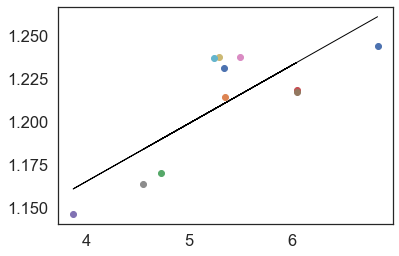

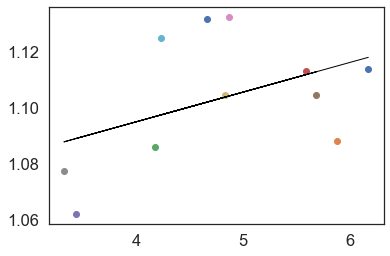

In [20]:
for marker in  ['PVALB']: #, 'SST', 'VIP', 'GAD1', 'GAD2']:
    for t, age in enumerate([cbpd_wide, adults]):
        print(t)
        wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in age], :]
        wide = wide[wide.sa>-1].sort_values('sa')
        wide = wide.loc[:, ['sa', 'donor_id', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']].groupby(['sa', 'donor_id']).median().reset_index()
        wide = pd.merge(wide, gene_columns.loc[:, ['donor_id', 'age']], on='donor_id')    
        figure = plt.figure()
        wide_age = wide.loc[[x for x in wide.index if wide.loc[x,'age'] in age], :]
        wide_mean = wide_age.loc[:, ['sa', 'donor_id', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']].groupby(['sa']).median().reset_index()
        wide_std = wide_age.loc[:, ['sa', 'donor_id', 'PVALB', 'SST', 'VIP', 'GAD1', 'GAD2']].groupby(['sa']).sem().reset_index()
        X = sm.add_constant(wide_mean[marker].values)
        df_x = pd.DataFrame(wide_mean[marker].values)
        if t == 1:
            results = sm.OLS([float(x) for x in child['H'].values], X).fit()
            print(results.summary())
            df_y = pd.DataFrame(child['H'].values)
            for i in np.arange(11):
                plt.scatter(wide_mean[marker].values[i], child['H'].values[i])
            fc_ctx_p, fc_ctx_d = shuf_test(wide_mean[marker], [float(t) for t in child['H']], type='pearson', n_rot=1000, null_dist=True)
            print([marker, t, fc_ctx_p])
            wide_mean['Hurst'] = [float(x) for x in child['H'].values]
            child_mean = wide_mean
        else:
            results = sm.OLS([float(x) for x in adult['H'].values], X).fit()
            print(results.summary())
            df_y = pd.DataFrame(adult['H'].values)
            for i in np.arange(11):
                plt.scatter(wide_mean[marker].values[i], adult['H'].values[i])
            fc_ctx_p, fc_ctx_d = shuf_test(wide_mean[marker], [float(t) for t in adult['H']], type='pearson', n_rot=1000, null_dist=True)
            print([marker, t, fc_ctx_p])
            wide_mean['Hurst'] = [float(x) for x in adult['H'].values]
            adult_mean = wide_mean
        mod = LinearRegression()
        mod_lin = mod.fit(df_x, df_y)
        y_lin_fit = mod_lin.predict(df_x)
        r2_lin = mod.score(df_x, df_y)
        plt.plot(df_x[0].values, [y[0] for y in y_lin_fit], color = '#000000', linewidth=1)
        #plt.ylim([1.0,1.25])
        #plt.xlim([3,5])
        plt.savefig('Fig2_' + marker+str(t)+'.eps',  format='eps', bbox_inches='tight')
        #plt.legend(adult.region.values)

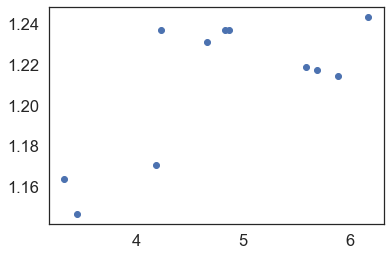

In [43]:
plt.scatter(adult_mean.PVALB, adult_mean.Hurst)

In [44]:
child_mean['sa'] = [1,2,7,3,9,4,6,8,10,11,5]
adult_mean['sa'] = [1,2,7,3,9,4,6,8,10,11,5]
child_mean.to_csv('child_mean.csv', index=False)
adult_mean.to_csv('adult_mean.csv', index=False)

In [21]:
wide

,sa,donor_id,PVALB,SST,VIP,GAD1,GAD2,age
0,37.25,12832,6.941555,6.673782,3.436896,5.193293,4.665370,19 yrs
1,37.25,12832,6.941555,6.673782,3.436896,5.193293,4.665370,19 yrs
2,37.25,12832,6.941555,6.673782,3.436896,5.193293,4.665370,19 yrs
3,37.25,12832,6.941555,6.673782,3.436896,5.193293,4.665370,19 yrs
4,37.25,12832,6.941555,6.673782,3.436896,5.193293,4.665370,19 yrs
...,...,...,...,...,...,...,...,...
616,325.25,12300,4.663676,6.490132,3.249699,3.941023,3.842086,23 yrs
617,325.25,12300,4.663676,6.490132,3.249699,3.941023,3.842086,23 yrs
618,325.25,12300,4.663676,6.490132,3.249699,3.941023,3.842086,23 yrs
619,325.25,12300,4.663676,6.490132,3.249699,3.941023,3.842086,23 yrs
